<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day14_Text_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
!pip install nltk -q

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwards', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Error loading stopwards: Package 'stopwards' not found in
[nltk_data]     index


Why Text is Different

**Numeric data:** Ready for models (just scale)

**Text data:** Models can't read words! Need to convert to numbers.

| Challenge | Solution |
|-----------|----------|
| Words are not numbers | Vectorization (BoW, TF-IDF) |
| "Running" vs "run" | Stemming/Lemmatization |
| "The", "is", "a" add noise | Stopword removal |
| Punctuation, cases | Text cleaning |
| High dimensionality | Feature selection, embeddings |

In [3]:
# Load SMS Spam dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

print(df.shape)
df.head(10)

(5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
#check class distribution
print(df['label'].value_counts())
print(f"Spam rate: {(df['label'] == 'spam').mean():.1%}")

label
ham     4825
spam     747
Name: count, dtype: int64
Spam rate: 13.4%


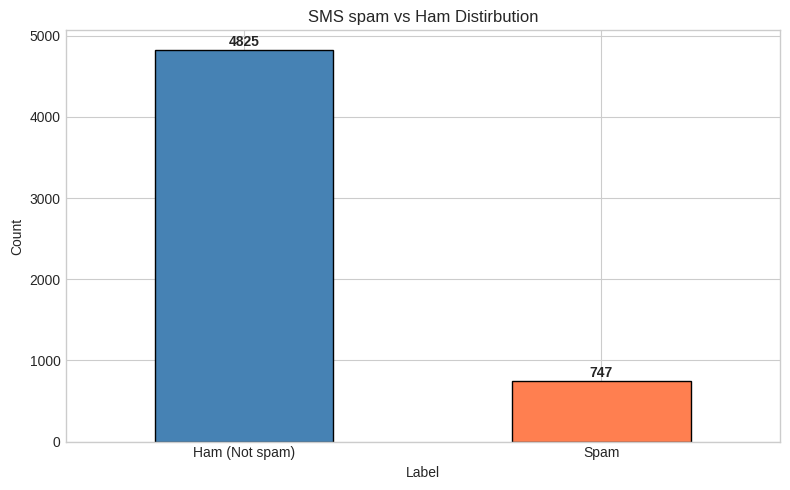

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

df['label'].value_counts().plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='black')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('SMS spam vs Ham Distirbution')
ax.set_xticklabels(['Ham (Not spam)', 'Spam'], rotation=0)

#Add counts on bars
for i, v in enumerate(df['label'].value_counts()):
  ax.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
print("SPAM Examples:")

for msg in df[df['label'] == 'spam']['message'].head(3):
  print(f" {msg[:100]}")
  print()

print("HAM Examples:")

for msg in df[df['label'] == 'ham']['message'].head(3):
  print(f" {msg[:100]}")
  print()

SPAM Examples:
 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr

 FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it s

 WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim

HAM Examples:
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a

 Ok lar... Joking wif u oni...

 U dun say so early hor... U c already then say...



In [7]:
#Basic stats
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

print(df.groupby('label')[['message_length', 'word_count']].describe())

      message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
ham           4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0   
spam           747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0  
spam       747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0  


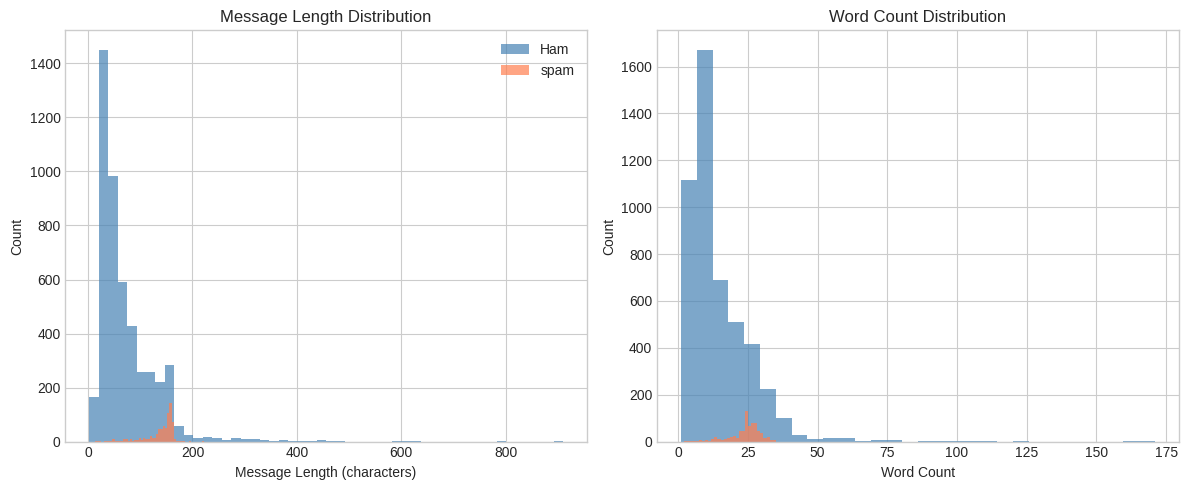

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#message length
df[df['label'] == 'ham']['message_length'].hist(ax=axes[0], bins=50, alpha=0.7, label='Ham', color='steelblue')
df[df['label'] == 'spam']['message_length'].hist(ax=axes[0], bins=50, alpha=0.7, label='spam', color='coral')

axes[0].set_xlabel("Message Length (characters)")
axes[0].set_ylabel("Count")
axes[0].set_title("Message Length Distribution")
axes[0].legend()

#word count
df[df['label'] == 'ham']['word_count'].hist(ax=axes[1], bins=30, alpha=0.7, label='Ham', color='steelblue')
df[df['label'] == 'spam']['word_count'].hist(ax=axes[1], bins=30, alpha=0.7, label='Spam', color='coral')
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Count")
axes[1].set_title("Word Count Distribution")

plt.tight_layout()
plt.show()

# Spam messages tend to be LONGER than ham messages!

Text Cleaning

In [9]:
def clean_text(text):
  """Some basic text cleaning"""
  #lower case
  text = text.lower()

  #remove urls
  text = re.sub(r'http\s+|www\s+', '', text)

  #remove email
  text = re.sub(r'\s+@\s+', '', text)

  #remove phone numbers
  text = re.sub(r'\d{5,}', '', text)

  #remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  #remove extra whitspace
  text = ' '.join(text.split())

  return text

print(f"Orginal text: {df['message'][0]}")
print(f"Cleaned text: {clean_text(df['message'][0])}")

Orginal text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned text: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


In [10]:
#Apply to all messages
df['message_clean'] = df['message'].apply(clean_text)

print("Cleaned messages:")
df[['message', 'message_clean']].head()

Cleaned messages:


,message,message_clean
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


Tokenization - Splitting words into individual words (Tokens)

In [11]:
df['tokens'] = df['message_clean'].apply(word_tokenize)

print("Tokenized Messages:")
df[['message_clean', 'tokens']].head()

Tokenized Messages:


,message_clean,tokens
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


Stopword removal

In [12]:
import nltk
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

print(f"Stopwords: {stop_words}")

Stopwords: {'i', 'only', 'their', "i'm", 'if', 'mightn', 'on', 'and', 'at', 'his', "it'll", 'so', 'needn', 'those', 'from', "he'd", 'can', 'should', "they're", 'own', "she's", 'an', 'up', 'her', 'shouldn', 'won', 'your', 'ain', 'once', "you'll", 'above', 're', 'wasn', 'which', "don't", "i've", 'here', 'ourselves', "you've", 'am', "shouldn't", "hadn't", 's', 'd', 'him', 'out', "he's", 'weren', 'or', 'same', 'yours', 'being', "hasn't", 'a', 'will', "wasn't", 'some', 'whom', 'by', 'be', 'don', 'have', 'does', 'why', 'down', 'during', 'were', "you'd", 'because', "i'd", 'through', 'all', "won't", 'not', 'our', "should've", 'after', "they'd", 'did', "we've", "she'd", "it'd", 'just', "mustn't", "they've", "couldn't", 'against', 'these', 'other', "that'll", 'you', 'been', "doesn't", 'do', 'each', 'm', 'off', 'me', 'is', 'isn', 'no', 'yourself', "i'll", 'ma', 'wouldn', 'before', 'them', 'both', "didn't", 'had', 'didn', 'we', 'to', 'then', 'when', 'of', 'there', 'any', "she'll", 'again', 'until'

In [13]:
#remove stopwords
def remove_stopwords(tokens):
  return [word for word in tokens if word not in stop_words]

example_tokens = word_tokenize(df['message_clean'][0])
print(f"Original tokens: {example_tokens}")

Original tokens: ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


In [14]:
#Applying to all messages
df['tokens_no_stop'] = df['tokens'].apply(remove_stopwords)

#Compare token_counts
df['token_count_before'] = df['tokens'].apply(len)
df['token_count_after'] = df['tokens_no_stop'].apply(len)

print(f"Average token count before: {df['token_count_before'].mean():.2f}")
print(f"Average token count after: {df['token_count_after'].mean():.2f}")
print(f"Reduction: {(1 - df['token_count_after'].mean() / df['token_count_before'].mean()):.1%}")


Average token count before: 15.29
Average token count after: 9.36
Reduction: 38.8%


Stemming vs Lemmatization

**Stemming:** Chop off word endings (fast but crude)
- "running" → "run"
- "better" → "better" (doesn't know grammar)

**Lemmatization:** Use vocabulary to find base form (slower but smarter)
- "running" → "run"
- "better" → "good" (knows grammar!)

In [15]:
#initiate stemmer and lematizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#Examples
words = ['running', 'walking','ran', 'easily', 'fairly', 'better', 'studies']

print(f"{'word:<12'} {'stemmed:<12'} {'lemmatized:<12'}")

for word in words:
  stemmed = stemmer.stem(word)
  lemmatized = lemmatizer.lemmatize(word, pos='v') #pos v for verbs
  print(f"{word:<12} {stemmed:<12} {lemmatized:<12}")


word:<12 stemmed:<12 lemmatized:<12
running      run          run         
walking      walk         walk        
ran          ran          run         
easily       easili       easily      
fairly       fairli       fairly      
better       better       better      
studies      studi        study       


In [16]:
#Stemming function
def stem_tokens(tokens):
  return [stemmer.stem(word) for word in tokens]

def lemmatize_tokens(tokens):
  return [lemmatizer.lemmatize(word) for word in tokens]

# Example
example_tokens = ['winning', 'free', 'prizes', 'calls', 'texting']
print(f"Original:    {example_tokens}")
print(f"Stemmed:     {stem_tokens(example_tokens)}")
print(f"Lemmatized:  {lemmatize_tokens(example_tokens)}")

Original:    ['winning', 'free', 'prizes', 'calls', 'texting']
Stemmed:     ['win', 'free', 'prize', 'call', 'text']
Lemmatized:  ['winning', 'free', 'prize', 'call', 'texting']


In [17]:
#Applying stemming to data
df['tokens_stemmed'] = df['tokens_no_stop'].apply(stem_tokens)

print("Stemmed tokens:")
df[['tokens_no_stop', 'tokens_stemmed']].head()

Stemmed tokens:


,tokens_no_stop,tokens_stemmed
0,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


In [18]:
# Complete preprocessing function
def preprocess_text(text):
    """
    Complete text preprocessing pipeline.

    Steps:
    1. Lowercase
    2. Remove URLs and emails
    3. Remove punctuation
    4. Tokenize
    5. Remove stopwords
    6. Stem
    7. Join back to string
    """
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and stem
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]

    # Join back
    return ' '.join(tokens)


In [19]:
# Test it
test_msg = "WINNER!! You've won a FREE entry in our £1000 prize draw!!! Text WIN to 80085 NOW!!!"
print(f"Original:    {test_msg}")
print(f"Preprocessed: {preprocess_text(test_msg)}")

Original:    WINNER!! You've won a FREE entry in our £1000 prize draw!!! Text WIN to 80085 NOW!!!
Preprocessed: winner youv free entri £1000 prize draw text win 80085


In [20]:
df['message_processed'] = df['message'].apply(preprocess_text)

print("Sample processed meassages: ")
for i in range(5):
  print(f"\n[{df['label'].iloc[i].upper()}]")
  print(f" OriginalL: {df['message'].iloc[i][:60]}")
  print(f" Processed: {df['message_processed'].iloc[i][:60]}")

Sample processed meassages: 

[HAM]
 OriginalL: Go until jurong point, crazy.. Available only in bugis n gre
 Processed: jurong point crazi avail bugi great world buffet cine got am

[HAM]
 OriginalL: Ok lar... Joking wif u oni...
 Processed: lar joke wif oni

[SPAM]
 OriginalL: Free entry in 2 a wkly comp to win FA Cup final tkts 21st Ma
 Processed: free entri wkli comp win cup final tkt 21st may 2005 text 87

[HAM]
 OriginalL: U dun say so early hor... U c already then say...
 Processed: dun say earli hor alreadi say

[HAM]
 OriginalL: Nah I don't think he goes to usf, he lives around here thoug
 Processed: nah dont think goe usf live around though


Word Frequency analysis

In [21]:
spam_words = ' '.join(df[df['label'] == 'spam']['message_processed']).split()
ham_words = ' '.join(df[df['label'] == 'ham']['message_processed']).split()

#count frequencies
spam_freq = Counter(spam_words)
ham_freq = Counter(ham_words)

print(f"Unique words in spam: {len(spam_freq)}")
print(f"Unique words in ham: {len(ham_freq)}")

Unique words in spam: 2526
Unique words in ham: 6119


In [22]:
#top words in each class
print(f"Top 15 spam words: {spam_freq.most_common(15)}")
print(f"Top 15 ham words: {ham_freq.most_common(15)}")

Top 15 spam words: [('call', 366), ('free', 216), ('txt', 163), ('text', 138), ('mobil', 135), ('claim', 115), ('stop', 115), ('repli', 109), ('prize', 94), ('get', 87), ('tone', 73), ('servic', 72), ('send', 70), ('new', 69), ('nokia', 68)]
Top 15 ham words: [('get', 360), ('come', 295), ('call', 289), ('ltgt', 276), ('dont', 265), ('got', 244), ('like', 244), ('know', 244), ('ill', 240), ('love', 239), ('good', 225), ('time', 219), ('day', 215), ('want', 213), ('need', 176)]


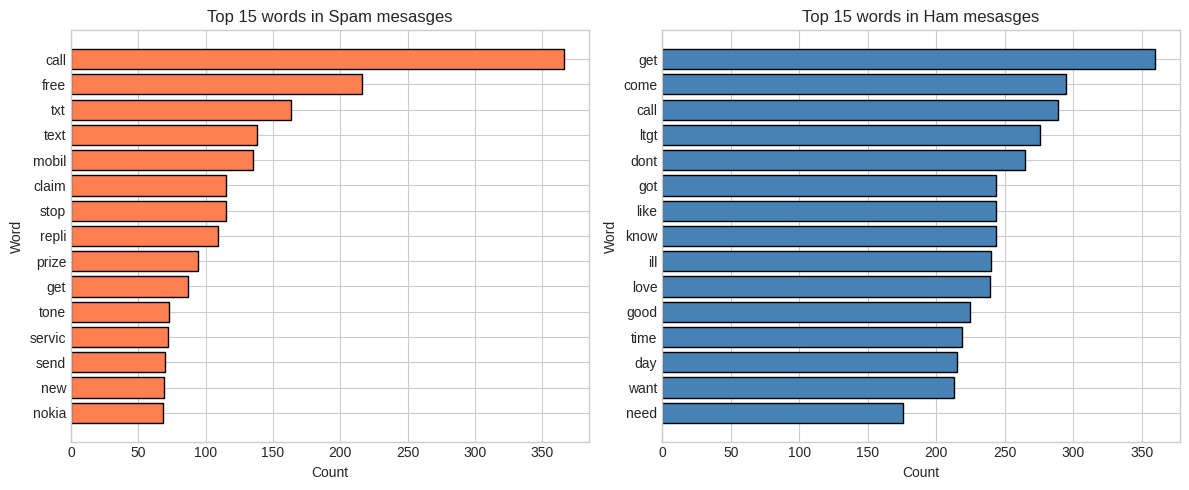

In [23]:
#visualize them
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Spam words
spam_top = spam_freq.most_common(15)
axes[0].barh([w[0] for w in spam_top], [w[1] for w in spam_top], color='coral', edgecolor='black')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Word")
axes[0].set_title("Top 15 words in Spam mesasges")
axes[0].invert_yaxis()

# Ham Words
ham_top = ham_freq.most_common(15)
axes[1].barh([w[0] for w in ham_top], [w[1] for w in ham_top], color='steelblue', edgecolor='black')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Word")
axes[1].set_title("Top 15 words in Ham mesasges")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [24]:
#Unique words in spam
spam_unique = {word: count for word, count in spam_freq.items()
                            if count > 10 and ham_freq.get(word, 0) < 5}

print("Words mostly in spam but not in ham:")
sorted_unique = sorted(spam_unique.items(), key=lambda x: x[1], reverse=True)[:20]
for word, count in sorted_unique:
  print(f" {word}: {count} (ham: {ham_freq.get(word, 0)})")
#

Words mostly in spam but not in ham:
 claim: 115 (ham: 0)
 prize: 94 (ham: 0)
 tone: 73 (ham: 0)
 nokia: 68 (ham: 3)
 award: 66 (ham: 1)
 urgent: 63 (ham: 2)
 guarante: 51 (ham: 0)
 latest: 37 (ham: 3)
 voucher: 36 (ham: 1)
 £1000: 35 (ham: 0)
 150ppm: 34 (ham: 0)
 landlin: 34 (ham: 2)
 camera: 33 (ham: 3)
 rington: 31 (ham: 0)
 £2000: 31 (ham: 0)
 video: 30 (ham: 2)
 appli: 29 (ham: 4)
 code: 29 (ham: 1)
 rate: 29 (ham: 3)
 tc: 29 (ham: 0)


Bag of Words (CountVectorizer)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=3000)

x_counts = count_vectorizer.fit_transform(df['message_processed'])

print(f"BoW Matrix shape: {x_counts.shape}")
print(f"   {x_counts.shape[0]} documents")
print(f"   {x_counts.shape[1]} unique words")

BoW Matrix shape: (5572, 3000)
   5572 documents
   3000 unique words


In [33]:
#Looking at the vocabulary
vocab = count_vectorizer.get_feature_names_out()
print(f"Vocabulary: {list(vocab[:20])}")
print(f"Vocabulary: {list(vocab[-20:])}")


Vocabulary: ['01223585334', '020603', '0207', '02073162414', '020903', '021', '050703', '0578', '071104', '07123456789', '07734396839', '07742676969', '0776xxxxxxx', '07786200117', '07xxxxxxxxx', '0800', '08000839402', '08000930705', '08000938767', '08001950382']
Vocabulary: ['yesterday', 'yet', 'yetund', 'yiju', 'yoga', 'yogasana', 'yor', 'youclean', 'youd', 'youll', 'your', 'youv', 'yr', 'yummi', 'yun', 'yunni', 'yuo', 'yup', 'zed', 'üll']


TF-IDF (Term Frequency-Inverse Document Frequency)

**Problem with BoW:** Common words get high counts even if they're not important.

**TF-IDF solves this:**
- **TF (Term Frequency):** How often word appears in THIS document
- **IDF (Inverse Document Frequency):** How rare is this word across ALL documents

**Result:** Rare, distinctive words get high scores. Common words get low scores.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
x_tfidf = tfidf_vectorizer.fit_transform(df['message_processed'])

print(f"TF-IDF Matrix shape: {x_tfidf.shape}")

TF-IDF Matrix shape: (5572, 3000)


Bulding a Spam Classifier

In [40]:
from sklearn.model_selection import train_test_split

#Prepare data
x = df['message_processed']
y = (df['label'] == 'spam').astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training size: {len(x_train)}")
print(f"Testing size: {len(x_test)}")

Training size: 4457
Testing size: 1115


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

#Model 1: Naive Bayes with CountVectorizer
pipeline_nb_count = Pipeline([
    ('vectorizer', CountVectorizer(max_features=3000)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count.fit(x_train, y_train)
y_pred_nb_count = pipeline_nb_count.predict(x_test)

print("Model 1: Naive Bayes with CountVectorizer")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_count):.2%}")
print(f"Classification report:\n {classification_report(y_test, y_pred_nb_count, target_names=['Ham', 'Spam'])}")

Model 1: Naive Bayes with CountVectorizer
Accuracy: 98.03%
Classification report:
               precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       966
        Spam       0.94      0.91      0.92       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [44]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

#model 2: Naive Bayes TF-IDF
pipeline_nb_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=3000)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf.fit(x_train, y_train)
y_pred_nb_tfidf = pipeline_nb_tfidf.predict(x_test)

print("Model 2: Naive Bayes with TF-IDF")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_tfidf):.1%}")
print(f"Classification report:\n {classification_report(y_test, y_pred_nb_tfidf, target_names=['Ham', 'Spam'])}")

Model 2: Naive Bayes with TF-IDF
Accuracy: 97.0%
Classification report:
               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [49]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

#Model 3: Logistic regression with tfidf
pipeline_lr_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=3000)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_lr_tfidf.fit(x_train, y_train)
y_pred_lr_tfidf = pipeline_lr_tfidf.predict(x_test)

print("Model 3: Logistic Regression with TF-IDF")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_tfidf):.1%}")
print(f"Classification report: {classification_report(y_test, y_pred_lr_tfidf, target_names=['Ham', 'Spam'])}")

Model 3: Logistic Regression with TF-IDF
Accuracy: 96.2%
Classification report:               precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [51]:
#Comparing all the models
models = [
    ('NB + Count', y_pred_nb_count),
    ('NB + TFIDF', y_pred_nb_tfidf),
    ('LR + TFIDF', y_pred_lr_tfidf)
]

print("Model Comparison:")

from sklearn.metrics import precision_score, recall_score

for name, y_pred in models:
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  print(f"{name}: Accuracy: {acc:.1%}, Precision: {prec:.1%}, Recall: {rec:.1%}")

Model Comparison:
NB + Count: Accuracy: 98.0%, Precision: 94.4%, Recall: 90.6%
NB + TFIDF: Accuracy: 97.0%, Precision: 99.1%, Recall: 77.9%
LR + TFIDF: Accuracy: 96.2%, Precision: 99.1%, Recall: 72.5%


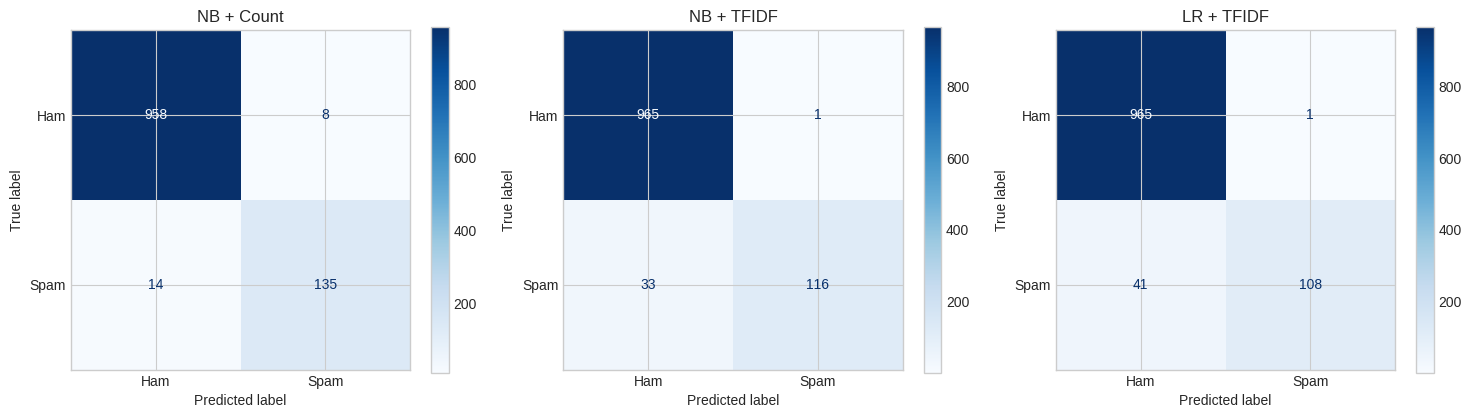

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, y_pred) in zip(axes, models):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          display_labels=['Ham', 'Spam'], cmap='Blues', ax=ax)
  ax.set_title(name)

plt.tight_layout()
plt.show()

Feature Importance - What indicates spam?

In [60]:
feature_names = pipeline_lr_tfidf.named_steps['vectorizer'].get_feature_names_out()
coefficients = pipeline_lr_tfidf.named_steps['classifier'].coef_[0]

#create df
feature_importance = pd.DataFrame({'Feature': feature_names, 'coefficient': coefficients}).sort_values('coefficient', ascending=False)

print("Top 15 spam indicators:")
print(feature_importance.head(15))

Top 15 spam indicators:
     Feature  coefficient
2742     txt     5.097765
713    claim     3.770808
2187   repli     3.318062
2499    stop     3.292630
1785   mobil     3.242203
2311  servic     3.241598
2618    text     3.041048
1174    free     2.833601
2078   prize     2.788433
619     call     2.524943
2784  urgent     2.510774
2688    tone     2.459730
2917     win     2.420962
446    award     2.209789
185      500     2.184814


In [61]:
print("Top 15 Ham indicators (negative coefficients):")
print(feature_importance.tail(15))

Top 15 Ham indicators (negative coefficients):
     Feature  coefficient
1257    good    -1.026081
1315   happi    -1.029879
1247      go    -1.044802
2494   still    -1.058715
2374     sir    -1.105527
2945    work    -1.175488
1636     lor    -1.221847
1340     hey    -1.255974
1563   later    -1.269721
744     come    -1.272321
1266     got    -1.335777
2439   sorri    -1.343633
1361    home    -1.432356
1411     ill    -1.804129
1663    ltgt    -2.074848


Feature  coefficient
   good    -1.026081
  happi    -1.029879
     go    -1.044802
  still    -1.058715
    sir    -1.105527
   work    -1.175488
    lor    -1.221847
    hey    -1.255974
  later    -1.269721
   come    -1.272321
    got    -1.335777
  sorri    -1.343633
   home    -1.432356
    ill    -1.804129
   ltgt    -2.074848


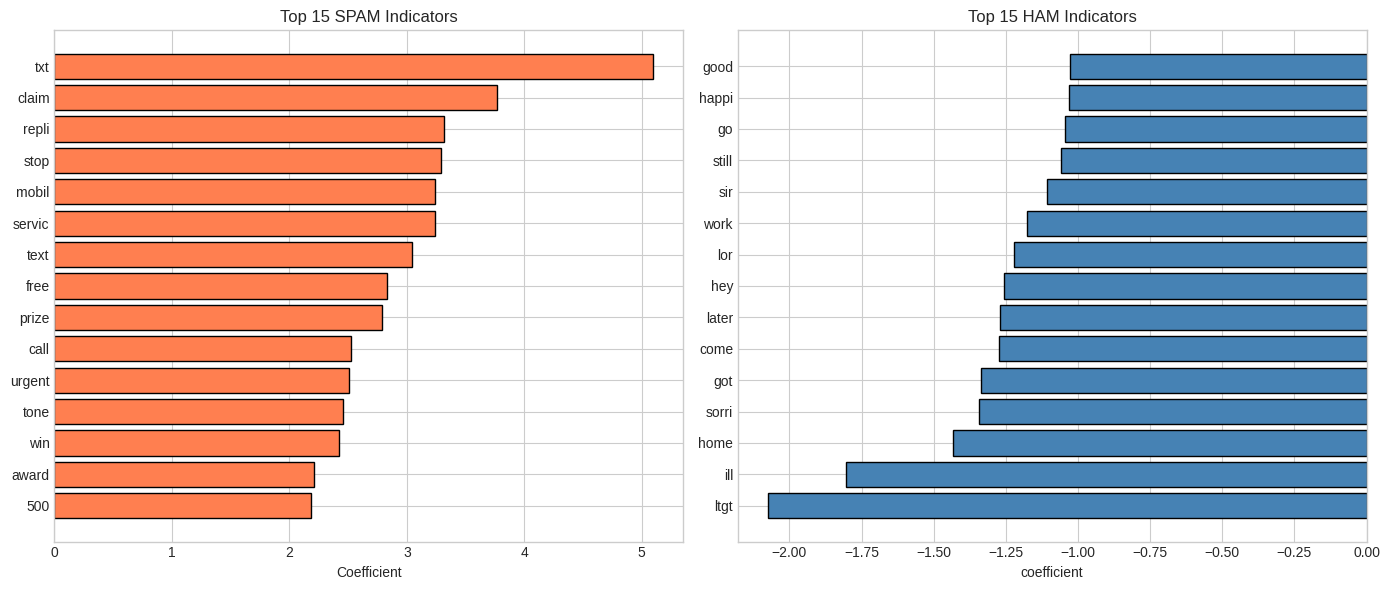

In [63]:
print(feature_importance.tail(15).to_string(index=False))
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Spam indicators
top_spam = feature_importance.head(15);
axes[0].barh(top_spam['Feature'], top_spam['coefficient'], color='coral', edgecolor='black')
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 15 SPAM Indicators')
axes[0].invert_yaxis()

# Ham indicators
top_ham = feature_importance.tail(15);
axes[1].barh(top_ham['Feature'], top_ham['coefficient'], color='steelblue', edgecolor='black')
axes[1].set_xlabel('coefficient')
axes[1].set_title('Top 15 HAM Indicators')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [64]:
#Testing on new messages
new_messages = [
    "Congratulations! You've won a free iPhone! Click here to claim now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your account has been compromised. Call 1-800-SCAM now!",
    "Can you pick up some milk on your way home?",
    "FREE entry in 2 a wkly comp to win FA Cup final tkts. Text FA to 87121",
    "I'll be there in 10 minutes",
    "You have been selected for a cash prize! Reply WIN to claim your £1000"
]

#Preprocess and predict
new_processed = [preprocess_text(msg) for msg in new_messages]
predictions = pipeline_lr_tfidf.predict(new_processed)
probabilities = pipeline_lr_tfidf.predict_proba(new_processed)

print("Predictions:")
print("="*67)

for msg, pred, prob in zip(new_messages, predictions, probabilities):
    label = "🚨 SPAM" if pred == 1 else "✅ HAM"
    confidence = prob[1] if pred == 1 else prob[0]
    print(f"\n{label} ({confidence:.1%} confidence)")
    print(f"  \"{msg[:60]}...\"" if len(msg) > 60 else f"  \"{msg}\"")

Predictions:

🚨 SPAM (58.3% confidence)
  "Congratulations! You've won a free iPhone! Click here to cla..."

✅ HAM (98.8% confidence)
  "Hey, are we still meeting for lunch tomorrow?"

🚨 SPAM (61.6% confidence)
  "URGENT: Your account has been compromised. Call 1-800-SCAM n..."

✅ HAM (98.6% confidence)
  "Can you pick up some milk on your way home?"

🚨 SPAM (56.0% confidence)
  "FREE entry in 2 a wkly comp to win FA Cup final tkts. Text F..."

✅ HAM (97.6% confidence)
  "I'll be there in 10 minutes"

🚨 SPAM (98.0% confidence)
  "You have been selected for a cash prize! Reply WIN to claim ..."


## Key Takeaways

### Text Preprocessing Steps:

| Step | Purpose | Example |
|------|---------|--------|
| **Lowercasing** | Normalize case | "Hello" → "hello" |
| **Remove punctuation** | Clean noise | "Hello!!!" → "Hello" |
| **Tokenization** | Split into words | "hello world" → ["hello", "world"] |
| **Stopwords** | Remove common words | ["this", "is", "spam"] → ["spam"] |
| **Stemming** | Reduce to root (fast) | "running" → "run" |
| **Lemmatization** | Reduce to base (smart) | "better" → "good" |

### Vectorization Methods:

| Method | How It Works | Best For |
|--------|--------------|----------|
| **Bag of Words** | Count word occurrences | Simple, interpretable |
| **TF-IDF** | Weight by importance | Better for most tasks |

### Model Results:

| Model | Accuracy | Notes |
|-------|----------|-------|
| Naive Bayes + Count | ~97% | Fast, simple baseline |
| Naive Bayes + TF-IDF | ~96% | Similar performance |
| Logistic Regression + TF-IDF | ~97% | Interpretable coefficients |

